## In this Colab we:
1. import list of latin names (ex. emma, justin etc.)
1. prepare & encode data
    - 'emma' : [e  m  m] -> [a]
    - tensor : [5 13 13] -> [1]
    - split train-dev-test

1. Define 'lego-block' classes for NN
1. initialize trainable embedding matrix C.shape = [vocab_size(27) , **EMB_SIZE** (2)]
    - map any of 27 letter encodings to its embedding. ex. [0] -> [0.14, 2.14, -1.65, 0.76]
1. Initialize trainable architecture:
    - z = emb @ hidden_W + hidden_b
        - z = BatchNorm(z)?
    - h = tanh(z)
    - logits = h @ out_W + out_b
    - F.cross_entropy(logits, Y_true)
1. train for **N_EPOCHS**
1. Compute train & dev loss. Vizualize it

## Result:
1. vizualize smart initialization improvements:
    - 0.1 * hidden_W
    - 0.01 * out_W
2. vizualize motivation for 1/sqrt(N) normalization
3. introduce **BatchNorm** and discuss its keypoints

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from zero2hero import makemore

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
words = open('../docs/names.txt', 'r').read().splitlines()
print(f'{len(words)=}')
words[:7]

len(words)=32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']

In [6]:
# build vocab + vLook-Up tables
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(chars + ['.'])

In [14]:
WINDOW = 3          # how many previous element to consider

# BUILD DATA given WINDOW size

# example 'emma', WINDOW == 3
# context -> output  |  torch.tensor:
#  [...]  -> 'e'     |  [ 0, 0, 0] -> [5]
#  [..e]  -> 'm'     |  [ 0, 0, 5] -> [13]
#  [.em]  -> 'm'     |  [ 0, 5,13] -> [13]
#  [emm]  -> 'a'     |  [ 5,13,13] -> [1]
#  [mma]  -> '.'     |  [13,13, 1] -> [0]


X, Y = [], []

for w in words:

    context = [0] * WINDOW
    for ch in w + '.' :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix] # update context

X = torch.tensor(X)
Y = torch.tensor(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print('Example X[0]:')
print(f"{list(words[0][:-1])} -> '{words[0][-1]}'")
print(f'{X[0]} -> {Y[0]}')
print(f'{ X_train.shape=} \n{ y_train.shape=}')
print(f'{ y_dev.shape=} \n{ y_test.shape=}')

Example X[0]:
['e', 'm', 'm'] -> 'a'
tensor([0, 0, 0]) -> 5
 X_train.shape=torch.Size([184797, 3]) 
 y_train.shape=torch.Size([184797])
 y_dev.shape=torch.Size([20534]) 
 y_test.shape=torch.Size([22815])


### Create simple Embeddings & Neural Network

In [33]:
EMB_SIZE = 10        # dimention of embedding space
HIDDEN_SIZE = 200   # size of hidden layer

# BUILD ARCHITECTURE
layers = [
    makemore.nn.Embeddings(vocab_size, HIDDEN_SIZE),
    makemore.nn.Flatten(),
    makemore.nn.Linear(EMB_SIZE * WINDOW, HIDDEN_SIZE, bias=False),
    makemore.nn.BatchNorm1d(HIDDEN_SIZE),
    makemore.nn.Tanh(),
    makemore.nn.Linear(HIDDEN_SIZE, vocab_size),
]

# stable initialization 
with torch.no_grad():
    layers[-1].weight *= 0.1 # less confident last layer
                       # non-trainable (data-dependent)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

print('Total number of parameters:')
sum(p.nelement() for p in parameters)

Total number of parameters:


12097

In [34]:
# training params
LR = 0.1
N_EPOCHS = 200000
BATCH_SIZE = 32

loglossi = []

for epoch in range(N_EPOCHS):

    # -------- Forward-pass ---------------

    # mini batch
    ixs = torch.randint(0, X_train.shape[0], (BATCH_SIZE,),)

    # train embeddings
    emb = C[X_train[ixs]]                           # (batch, window, emb) ex. (32, 3, 10)
    x = emb.view(-1, WINDOW*EMB_SIZE)             #  (batch, window*emb) ex. (32, 30)

    for layer in layers:
        x = layer(x)

    # compute the loss
    loss = F.cross_entropy(x, y_train[ixs])
    
    # training
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = LR if epoch < 1//2 * N_EPOCHS else 0.1 * LR
    for p in parameters:
        p.data += -lr * p.grad
    
    # track proress
    if epoch % 10000 == 0:
        print(f'{epoch=}/{N_EPOCHS} : {loss.item():.4f}')
    loglossi.append(loss.log10().item())
    

epoch=0/200000 : 3.3194
epoch=10000/200000 : 2.1828
epoch=20000/200000 : 2.1836
epoch=30000/200000 : 2.1523
epoch=40000/200000 : 1.8448
epoch=50000/200000 : 2.2708
epoch=60000/200000 : 2.3401
epoch=70000/200000 : 2.1908
epoch=80000/200000 : 2.0111
epoch=90000/200000 : 2.2985
epoch=100000/200000 : 1.9976
epoch=110000/200000 : 2.2641
epoch=120000/200000 : 1.9540
epoch=130000/200000 : 1.8152


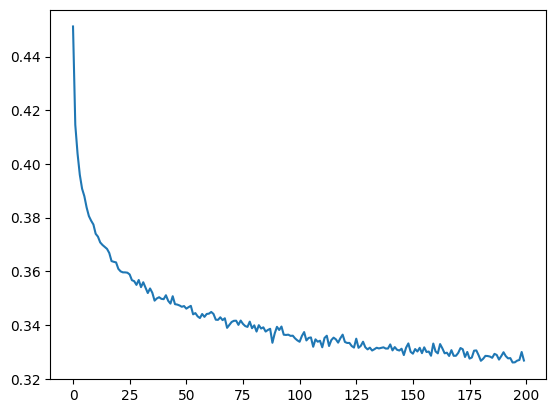

In [ ]:
smooth_loss = torch.tensor(loglossi).view(-1, 1000).mean(1)
plt.plot(smooth_loss)

In [ ]:
# switch to test mode
for layer in layers:
    layer.training = False

# compute loss score
@torch.no_grad()
def get_loss(split):
    assert split in ['train', 'dev', 'test'], f'{split} not yet supported'
    x,y = {
        'train' : (X_train, y_train),
        'dev'   : (X_dev, y_dev),
        'test'  : (X_test, y_test)
    }[split]

    emb = C[x]
    x = emb.view(-1, WINDOW * EMB_SIZE)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, y)
    print(f'{split}{loss.item()=}')


get_loss('train')
get_loss('test')

# original train (2.12) dev (2.16)
# fix over-softmax train (2.07) dev (2.13)
# fix saturated tanh train (2.037) dev (2.106)
# add Batch Norm train (2.06) dev (2.109)

trainloss.item()=2.108356475830078
testloss.item()=2.1450695991516113


In [ ]:
# Sample

for _ in range(20):

    out = []
    context = [0] * WINDOW
    while True:
        emb = C[torch.tensor(context)]
        emb = emb.view(1, -1)
        if BATCH_NORM:
            z = bn_gain * (emb @ hidden_W - bn_mean) / bn_std + bn_bias
        else:
            z = emb @ hidden_W + hidden_b
        h = torch.tanh(z)
        logits = h @ out_W + out_b
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

## Extra notes

### BatchNorm - helps stabilize the training of Deep NN
- for the first epoch, hidden sum func (aka z) is exactly ~ N(0,1). Then we learn gain*N(0,1) + bias

- mathematically, update of one particular neuron depends on other neurons in the given batch

    it creates leakage of gradient to other neurons due to substract & divide from normalization :(

- in PyTorch, torch.nn.BatchNorm1d internally keeps track of "running" mean and std, so don't forget to model.eva() during inference.

- for Linear layer (z = emb @ W + b), bias (b) becomes useless as we normalize (z) afterwards. So drop it off from architecture. **bn bias** replaces it